In [1]:
include("MiniCollectiveSpins.jl")
using PyPlot
using Statistics
using JLD2
import PhysicalConstants.CODATA2018: c_0
using Unitful
using ProgressMeter
using ProgressBars
using NonlinearSolve
using SteadyStateDiffEq
using Libdl
using Symbolics
using OrdinaryDiffEq

In [2]:
""" Prepare the initial vector u0 """
function u0_CFunction(phi_array, theta_array, op_list)
    u0 = ones(ComplexF64, length(op_list))
    for i in 1:length(op_list)
        if length(op_list[i]) == 1
            j = Int(op_list[i][1] % 10^floor(log10(abs(op_list[i][1]))-1)) # Atom nbr
            if parse(Int, string(op_list[i][1])[1:2]) == 22
                u0[i] = cos(theta_array[j]/2)^2
            elseif parse(Int, string(op_list[i][1])[1:2]) == 21
                u0[i] = cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
            else
                println(op_list[i][1])
            end
        end

        if length(op_list[i]) == 2
            for op in op_list[i]
                j = Int(op % 10^floor(log10(abs(op))-1)) # Atom nbr
                if parse(Int, string(op)[1:2]) == 22
                    u0[i] *= cos(theta_array[j]/2)^2
                elseif parse(Int, string(op)[1:2]) == 21
                    u0[i] *= cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
                elseif parse(Int, string(op)[1:2]) == 12
                    u0[i] *= cos(theta_array[j]/2)*exp(-1im*phi_array[j])*sin(theta_array[j]/2)
                else
                    println(op)
                end
            end
        end
    end
    return u0
end

""" Function loading the block subfunction when a lot of equations are involved """
function load_f(fname::String, libpath::String)
	lib = Libdl.dlopen(libpath)
	fptr = Libdl.dlsym(lib, fname)
	return (du, u, params) -> ccall(fptr, Cvoid, (Ptr{ComplexF64}, Ptr{ComplexF64}, Ptr{ComplexF64}), du, u, params)
end

""" Create a random distribution, save it, computes the corresponding parameters an return the stationnary state. 
If compute_t_evolution, compute the whole evolution, else only the stationnary state. """
function solve_random_distrib(chunk, op_list, compute_t_evolution, fcounter, N)
    popup_SS, popup_t = [], []
    for i in chunk
        # Compute distribution
        r0 = [[rand(Float64)*Lx, rand(Float64)*Ly, rand(Float64)*Lz] for i in 1:N]
        # Save the atoms position for comparison with QuantumOptics
        @save "r0/r0_N_$(N)_r_$i.jdl2" r0

        # Normalize the position vectors
        r0 = r0 / λ

        # Compute the parameters
        system = SpinCollection(r0, e, gammas=1.)
        Ω_CS = OmegaMatrix(system)
        Γ_CS = GammaMatrix(system)
        Γij_ = [Γ_CS[i, j] for i = 1:N for j=1:N]
        Ωij_ = [Ω_CS[i, j] for i = 1:N for j=1:N if i≠j]
        exp_RO_ = [exp(1im*r0[i]'kl) for i = N:-1:1] # We go in the decreasing direction to avoid exp_RO(10) being replace by exp_RO(1)0
        conj_exp_RO_ = [exp(-1im*r0[i]'kl) for i = N:-1:1]
        p0 = ComplexF64.([Γij_; Ωij_; exp_RO_; conj_exp_RO_; Ω_RO/2])

        # Load the functions
        fsolve(du, u, p, t) = functions[fcounter](du, u, p0)

        ## Compute stationnary state ##
        # Prepare the guess for the steady state
        phi_array_f, theta_array_f = zeros(N), ones(N)*3π/4
        uf = u0_CFunction(phi_array_f, theta_array_f, op_list)

        # Compute stationnary state
        prob_ss = SteadyStateProblem(fsolve, uf)
        sol_ss = solve(prob_ss, SSRootfind())
        stationnary_state = sum(real(sol_ss[1:N]))
        push!(popup_SS, stationnary_state)

        if compute_t_evolution
            # ## Compute time evolution ##
            # Prepare the initial state
            phi_array_0, theta_array_0 = zeros(N), ones(N)*π # We start from all the atoms in the GS
            u0 = u0_CFunction(phi_array_0, theta_array_0, op_list)

            # Computation
            prob = OrdinaryDiffEq.ODEProblem(fsolve, u0, (T[1], T[end]))
            sol = OrdinaryDiffEq.solve(prob, OrdinaryDiffEq.DP5(), saveat=T;
                        reltol=1.0e-6,
                        abstol=1.0e-8).u
            push!(popup_t, [sum(real(sol[i][1:N])) for i=1:length(T)])
        end
    end
    return popup_SS, popup_t
end

solve_random_distrib

### Define the system

In [3]:
# Nbr of particles
N_list = [4]#[2:2:10;];
r = 100 # Nbr of repetitions

# Normalisation parameters
λ = 421e-9
γ = 32.7e6 # In Hz

# Physical values
ω0 = (2π*ustrip(c_0)/λ)
ωl = ω0
kl = [ustrip(c_0)/ωl, 0, 0] # Laser along x
Ω_RO = 1e7 # Taken from Barbut arXiv:2412.02541v1

# Size of the box
Lx, Ly, Lz = [1, 1, 1] * 1e-6

# Normalization
ω0 = ω0 / γ
ωl = ωl / γ
kl = kl * λ
Ω_RO = Ω_RO / γ

# Quantization axis along z
e = [0, 0, 1.]

# Integration parameter
tstep = 1
T = [0:tstep:100;]; # Normalised time

In [4]:
# Prepare the wrapper
const N_FUNCS = length(N_list)  # Total function nbr
const functions = Vector{Function}(undef, N_FUNCS)

for (i, N) in enumerate(N_list)
    libpath ="libs/liballfuncs_$N.dll"
    functions[i] = load_f("diffeqf", libpath)
end

# Compute stationary state for each atom number

In [5]:
# Create the directories
if !isdir("r0")
    mkdir("r0")
end
if !isdir("Images_distribution")
    mkdir("Images_distribution")
end
if !isdir("solutions")
    mkdir("solutions")
end
nothing

In [6]:
list_r = 1:r
chunks = Iterators.partition(list_r, cld(length(list_r), Threads.nthreads()))
popup_SS_N, popup_t_N = [], []

for (i, N) in ProgressBar(enumerate(N_list))
    @load "op_list/op_list_$N.jdl2" op_list
    tasks = map(chunks) do chunk # Split the different distributions into chuncks solved on each core
        Threads.@spawn solve_random_distrib(chunk, op_list, true, i, N)
    end

    # Gather the data from the different threads
    sol_tasks = fetch.(tasks)
    push!(popup_SS_N, vcat([s[1] for s in sol_tasks]...))
    push!(popup_t_N, vcat([s[2] for s in sol_tasks]...))
end

0.0%┣                                                ┫ 0/1 [00:02<00:-2, -2s/it]
100.0%┣██████████████████████████████████████████┫ 1/1 [00:30<Inf:Inf, InfGs/it]
100.0%┣██████████████████████████████████████████┫ 1/1 [00:30<Inf:Inf, InfGs/it]


In [7]:
@save "solutions/sol_N_$(N_list)_r_$r" popup_SS_N popup_t_N

In [8]:
@load "solutions/sol_N_$(N_list)_r_$r" popup_SS_N popup_t_N

2-element Vector{Symbol}:
 :popup_SS_N
 :popup_t_N

# Plots

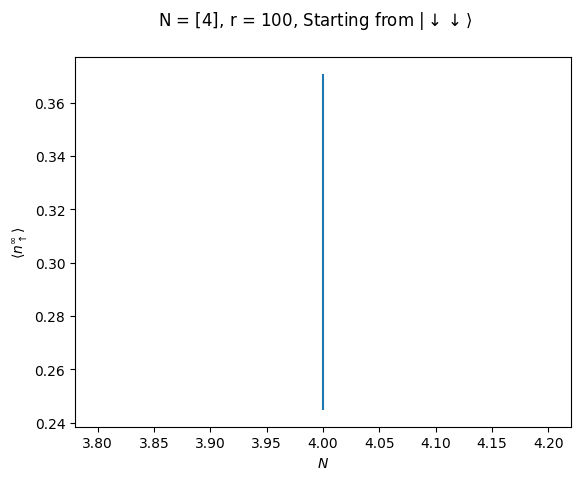

In [9]:
close("all")
fig = figure()
errorbar(N_list, [mean(popup_SS) for popup_SS in popup_SS_N], yerr=[std(popup_SS) for popup_SS in popup_SS_N])
xlabel(L"N")
ylabel(L"$\langle  n_{\uparrow}^\infty \rangle$")
suptitle("N = $N_list, r = $r, Starting from "*L"$|\downarrow \downarrow \rangle $")
pygui(false); gcf()
# pygui(true); show()

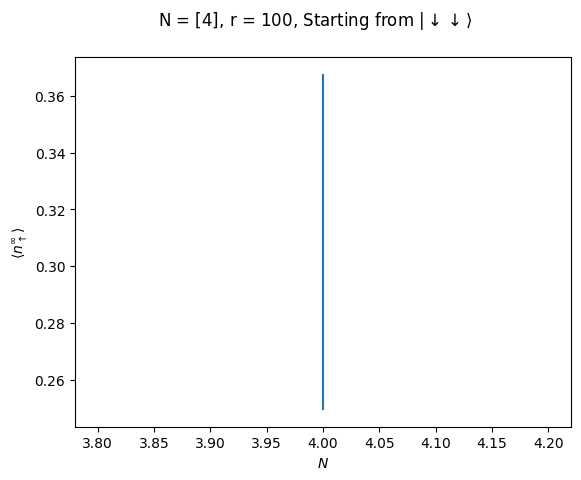

In [10]:
# Computation with the time evolution final point
close("all")
fig = figure()
errorbar(N_list, [mean(p, dims=1)[1][end] for p in popup_t_N], yerr=[std(p)[end] for p in popup_t_N])
xlabel(L"N")
ylabel(L"$\langle  n_{\uparrow}^\infty \rangle$")
suptitle("N = $N_list, r = $r, Starting from "*L"$|\downarrow \downarrow \rangle $")
pygui(false); gcf()
# pygui(true); show()

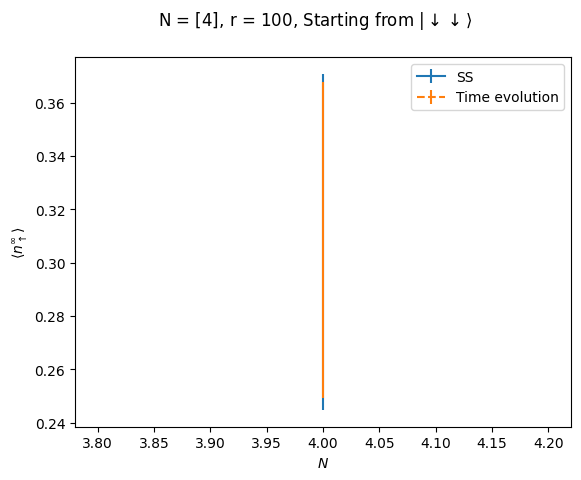

In [11]:
# Compare both
close("all")
fig = figure()
errorbar(N_list, [mean(popup_SS) for popup_SS in popup_SS_N], yerr=[std(popup_SS) for popup_SS in popup_SS_N], label="SS")
errorbar(N_list, [mean(p, dims=1)[1][end] for p in popup_t_N], yerr=[std(p)[end] for p in popup_t_N], label="Time evolution", linestyle="--")
legend()
xlabel(L"N")
ylabel(L"$\langle  n_{\uparrow}^\infty \rangle$")
suptitle("N = $N_list, r = $r, Starting from "*L"$|\downarrow \downarrow \rangle $")
pygui(false); gcf()
# pygui(true); show()

### Plot evolution

In [15]:
close("all")
fig = figure()
for (i, N) in enumerate(N_list)
    line_mean, = plot(T, mean(popup_t_N[i]))
    hlines(mean(popup_SS_N[i]), T[1], T[end], linestyle="--", color = line_mean.get_color())

    for j in 1:r
        line, = plot(T, popup_t_N[i][j], linewidth=0.6)
        hlines(mean(popup_SS_N[i][j]), T[1], T[end], linestyle="--", color = line.get_color(), linewidth=0.6)

    end

end
# errorbar(N_list, [mean(popup_SS) for popup_SS in popup_SS_N], yerr=[std(popup_SS) for popup_SS in popup_SS_N])
xlabel(L"\gamma t")
ylabel(L"$\langle  n_{\uparrow} \rangle$")
suptitle("N = $N_list, r = $r, Starting from "*L"$|\downarrow \downarrow \rangle $")
# pygui(false); gcf()
pygui(true); show()

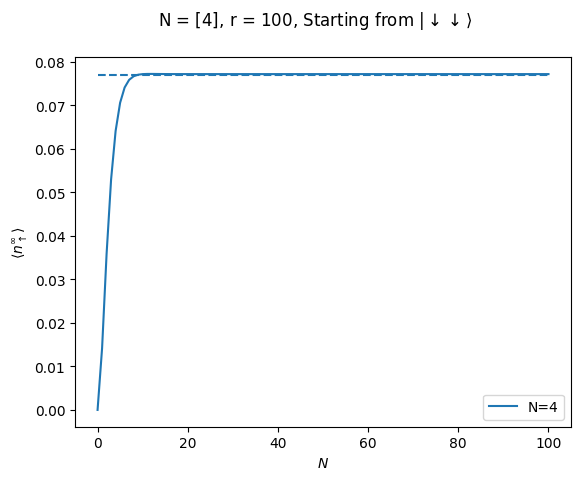

In [13]:
close("all")
fig = figure()
for (i, N) in enumerate(N_list)
    line_mean, = plot(T, mean(popup_t_N[i])/N, label="N=$N")
    hlines(mean(popup_SS_N[i])/N, T[1], T[end], linestyle="--", color = line_mean.get_color())
end
# errorbar(N_list, [mean(popup_SS) for popup_SS in popup_SS_N], yerr=[std(popup_SS) for popup_SS in popup_SS_N])
xlabel(L"N")
ylabel(L"$\langle  n_{\uparrow}^\infty \rangle$")
suptitle("N = $N_list, r = $r, Starting from "*L"$|\downarrow \downarrow \rangle $")
legend()
pygui(false); gcf()
# pygui(true); show()

# Try to find bugs in SS

In [16]:
popup_SS_N

1-element Vector{Any}:
 Any[0.23894435150475685, 0.3699172891101511, 0.17351002633487522, 0.2749459665028504, 0.3293529107680936, 0.26992746114620236, 0.3111405602369586, 0.3154250035816474, 0.2901869106526231, 0.316625246502977  …  0.4082793954148432, 0.25269353456209437, 0.3159061551152521, 0.4244576962812763, 0.21976727119385345, 0.26517214412987816, 0.26393704354830394, 0.21801870881501068, 0.2875914442147784, 0.30540083049592054]

In [17]:
close("all")
fig = figure()
i = 1

for j in 1:2:11
    line, = plot(T, popup_t_N[i][j], linewidth=1, label="$j")
    hlines(mean(popup_SS_N[i][j]), T[1], T[end], linestyle="--", color = line.get_color(), linewidth=1)
end
legend()
xlabel(L"\gamma t")
ylabel(L"$\langle  n_{\uparrow} \rangle$")
suptitle("N = $(N_list[i]), r = $r, Starting from "*L"$|\downarrow \downarrow \rangle $")
# pygui(false); gcf()
pygui(true); show()

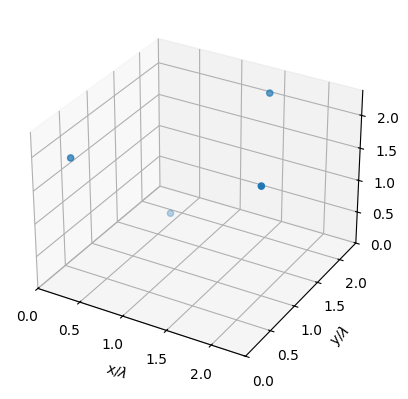

In [18]:
N = 4
j = 11
@load "r0/r0_N_$(N)_r_$j.jdl2" r0
close("all")
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter([r[1] for r in r0/λ], [r[2] for r in r0/λ], [r[3] for r in r0/λ])
ax.set_xlabel(L"x/$\lambda$"); ax.set_ylabel(L"y/$\lambda$"); ax.set_zlabel(L"z/$\lambda$")
ax.set_xlim(0, Lx/λ), ax.set_ylim(0, Ly/λ), ax.set_zlim(0, Lz/λ)
pygui(false); gcf()

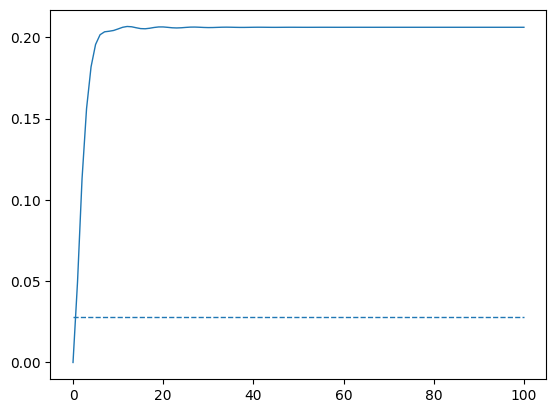

In [19]:
close("all")
fig = figure()
line, = plot(T, popup_t_N[end][j], linewidth=1, label="$j")
hlines(mean(popup_SS_N[end][j]), T[1], T[end], linestyle="--", color = line.get_color(), linewidth=1)
pygui(false); gcf()

### Stats on distance between atoms

In [20]:
popup_SS = popup_SS_N[end][j]
popup_SS

0.027721888364582163

In [ ]:
# d0 = zeros(r, N, N) # repetiton, atom i, distance from atom j
# for i = 1:r
#     @load "r0/r0_N_$(N)_r_$i.jdl2" r0
#     r0 = r0/λ # Normalisation
#     for j in 1:N
#         for k = 1:N
#             d0[i, j, k] = norm(r0[j]-r0[k])
#         end
#     end
# end

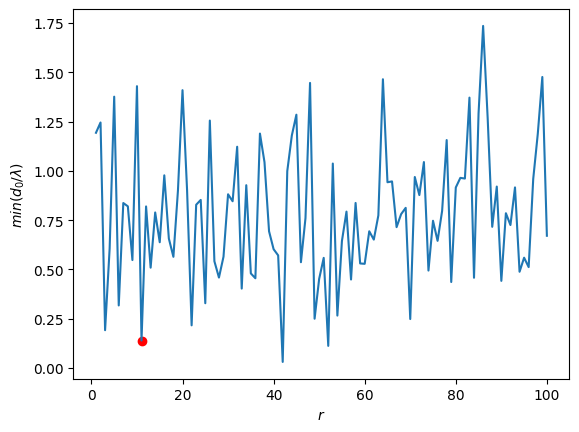

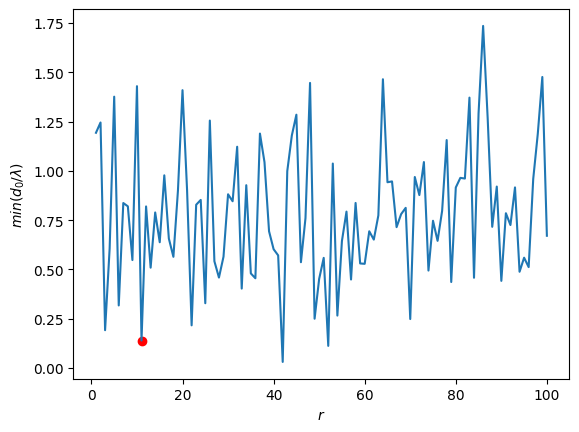

In [33]:
close("all")
figure()
plot([1:r;], [minimum(d0[i, :, :][d0[1, :, :] .> 0]) for i = 1:r])
scatter(j, minimum(d0[j, :, :][d0[1, :, :] .> 0]), color="red")
xlabel(L"r")
ylabel(L"min(d_0/\lambda)")
pygui(false); gcf()

In [30]:
# Compute stationnary state
prob_ss = SteadyStateProblem(fsolve, uf)

try
    sol_ss = solve(prob_ss, SSRootfind())
    stationnary_state = sum(real(sol_ss[1:N]))
    push!(popup_SS, stationnary_state)
catch e
    print(e)
end

ErrorException

┌ Error: BLAS/LAPACK dgetrf: Matrix is singular
│   Details: U(37,37) is exactly zero. The factorization has been completed, but U is singular and division by U will produce infinity.
│   Return code (info): 37
│   Matrix size: (38, 38)
│   Matrix type: Matrix{ComplexF64}
│   Element type: ComplexF64
│   Memory usage: 0.02 MB
│   RHS length: 38
│   RHS type: Vector{ComplexF64}
└ @ LinearSolve C:\Users\Joschka\.julia\packages\LinearSolve\t9kBc\src\mkl.jl:273


("BLAS/LAPACK dgetrf: Matrix is singular\n  Details: U(37,37) is exactly zero. The factorization has been completed, but U is singular and division by U will produce infinity.\n  Return code (info): 37\n  Matrix size: (38, 38)\n  Matrix type: Matrix{ComplexF64}\n  Element type: ComplexF64\n  Memory usage: 0.02 MB\n  RHS length: 38\n  RHS type: Vector{ComplexF64}")

In [26]:
popup_SS, popup_t = [], []
compute_t_evolution = true

# Compute the parameters
system = SpinCollection(r0, e, gammas=1.)
Ω_CS = OmegaMatrix(system)
Γ_CS = GammaMatrix(system)
Γij_ = [Γ_CS[i, j] for i = 1:N for j=1:N]
Ωij_ = [Ω_CS[i, j] for i = 1:N for j=1:N if i≠j]
exp_RO_ = [exp(1im*r0[i]'kl) for i = N:-1:1] # We go in the decreasing direction to avoid exp_RO(10) being replace by exp_RO(1)0
conj_exp_RO_ = [exp(-1im*r0[i]'kl) for i = N:-1:1]
p0 = ComplexF64.([Γij_; Ωij_; exp_RO_; conj_exp_RO_; Ω_RO/2])

# Load the functions
fsolve(du, u, p, t) = functions[i](du, u, p0)

## Compute stationnary state ##
# Prepare the guess for the steady state
@load "op_list/op_list_$N.jdl2" op_list
phi_array_f, theta_array_f = zeros(N), ones(N)*π/2
uf = u0_CFunction(phi_array_f, theta_array_f, op_list)

# Compute stationnary state
prob_ss = SteadyStateProblem(fsolve, uf)
sol_ss = solve(prob_ss, SSRootfind())
stationnary_state = sum(real(sol_ss[1:N]))
push!(popup_SS, stationnary_state)

if compute_t_evolution
    # ## Compute time evolution ##
    # Prepare the initial state
    phi_array_0, theta_array_0 = zeros(N), ones(N)*π # We start from all the atoms in the GS
    u0 = u0_CFunction(phi_array_0, theta_array_0, op_list)

    # Computation
    prob = OrdinaryDiffEq.ODEProblem(fsolve, u0, (T[1], T[end]))
    sol = OrdinaryDiffEq.solve(prob, OrdinaryDiffEq.DP5(), saveat=T;
                reltol=1.0e-6,
                
                abstol=1.0e-8).u
    push!(popup_t, [sum(real(sol[i][1:N])) for i=1:length(T)])
end

┌ Error: BLAS/LAPACK dgetrf: Matrix is singular
│   Details: U(37,37) is exactly zero. The factorization has been completed, but U is singular and division by U will produce infinity.
│   Return code (info): 37
│   Matrix size: (38, 38)
│   Matrix type: Matrix{ComplexF64}
│   Element type: ComplexF64
│   Memory usage: 0.02 MB
│   RHS length: 38
│   RHS type: Vector{ComplexF64}
└ @ LinearSolve C:\Users\Joschka\.julia\packages\LinearSolve\t9kBc\src\mkl.jl:273


ErrorException: BLAS/LAPACK dgetrf: Matrix is singular
  Details: U(37,37) is exactly zero. The factorization has been completed, but U is singular and division by U will produce infinity.
  Return code (info): 37
  Matrix size: (38, 38)
  Matrix type: Matrix{ComplexF64}
  Element type: ComplexF64
  Memory usage: 0.02 MB
  RHS length: 38
  RHS type: Vector{ComplexF64}

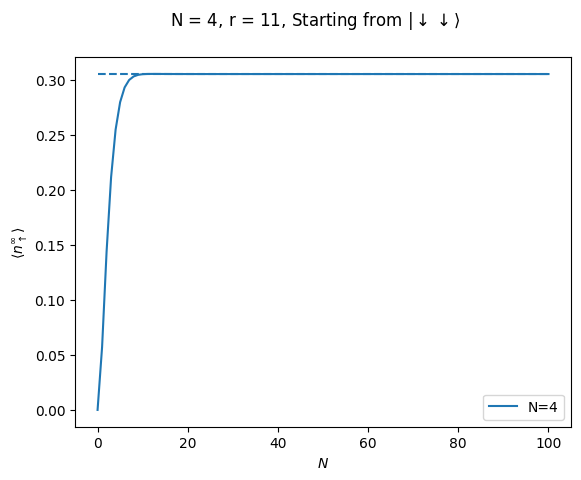

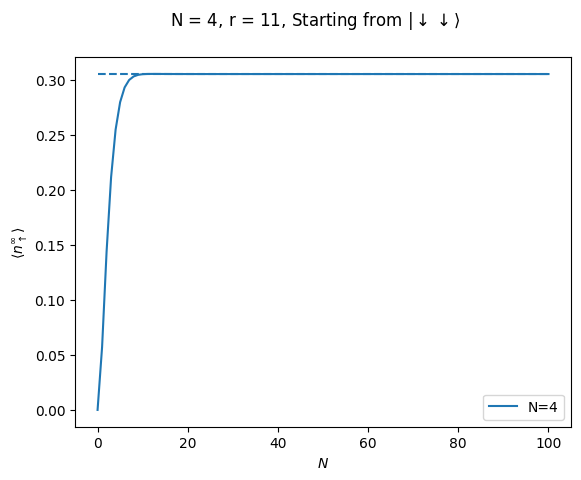

In [56]:
# close("all")
fig = figure()
line, = plot(T, mean(popup_t), label="N=$N")
hlines(popup_SS, T[1], T[end], linestyle="--", color = line.get_color())
# errorbar(N_list, [mean(popup_SS) for popup_SS in popup_SS_N], yerr=[std(popup_SS) for popup_SS in popup_SS_N])
xlabel(L"N")
ylabel(L"$\langle  n_{\uparrow}^\infty \rangle$")
suptitle("N = $N, r = $j, Starting from "*L"$|\downarrow \downarrow \rangle $")
legend()
pygui(false); gcf()
# pygui(true); show()

In [5]:
function solve_random_distrib_test(chunk, op_list, compute_t_evolution, fcounter, N)
    popup_SS, popup_t = [], []
    for i in chunk
        # Compute distribution
        r0 = [[rand(Float64)*Lx, rand(Float64)*Ly, rand(Float64)*Lz] for i in 1:N]
        # Save the atoms position for comparison with QuantumOptics
        @save "r0/r0_N_$(N)_r_$i.jdl2" r0

        # Normalize the position vectors
        r0 = r0 / λ

        # Compute the parameters
        system = SpinCollection(r0, e, gammas=1.)
        Ω_CS = OmegaMatrix(system)
        Γ_CS = GammaMatrix(system)
        Γij_ = [Γ_CS[i, j] for i = 1:N for j=1:N]
        Ωij_ = [Ω_CS[i, j] for i = 1:N for j=1:N if i≠j]
        exp_RO_ = [exp(1im*r0[i]'kl) for i = N:-1:1] # We go in the decreasing direction to avoid exp_RO(10) being replace by exp_RO(1)0
        conj_exp_RO_ = [exp(-1im*r0[i]'kl) for i = N:-1:1]
        p0 = ComplexF64.([Γij_; Ωij_; exp_RO_; conj_exp_RO_; Ω_RO/2])

        # Load the functions
        fsolve(du, u, p, t) = functions[fcounter](du, u, p0)

        ## Compute stationnary state ##
        # Prepare the guess for the steady state
        phi_array_f, theta_array_f = zeros(N), ones(N)*3π/4
        uf = u0_CFunction(phi_array_f, theta_array_f, op_list)

        # Compute stationnary state
        prob_ss = SteadyStateProblem(fsolve, uf)
        sol_ss = solve(prob_ss, SSRootfind())
        stationnary_state = sum(real(sol_ss[1:N]))
        push!(popup_SS, stationnary_state)

        if compute_t_evolution
            # ## Compute time evolution ##
            # Prepare the initial state
            phi_array_0, theta_array_0 = zeros(N), ones(N)*π # We start from all the atoms in the GS
            u0 = u0_CFunction(phi_array_0, theta_array_0, op_list)

            # Computation
            prob = OrdinaryDiffEq.ODEProblem(fsolve, u0, (T[1], T[end]))
            sol = OrdinaryDiffEq.solve(prob, OrdinaryDiffEq.DP5(), saveat=T;
                        reltol=1.0e-6,
                        abstol=1.0e-8).u
            push!(popup_t, [sum(real(sol[i][1:N])) for i=1:length(T)])
        end
        a = [sum(real(sol[i][1:N])) for i=1:length(T)]
        # println(abs(a[end] - popup_SS[end]))
        if abs(a[end] - popup_SS[end]) > 0.01
            println("Whatw")
        end
    end
    return popup_SS, popup_t
end

solve_random_distrib_test (generic function with 1 method)

In [6]:
solve_random_distrib_test(1:1000, op_list, true, 1, 4)

UndefVarError: UndefVarError: `op_list` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

# Brouillons

In [ ]:

    # @showprogress for j = 1:r
    #     r0 = [[rand(Float64)*Lx, rand(Float64)*Ly, rand(Float64)*Lz] for k in 1:N]
    #     # Save the atoms position for comparison with QuantumOptics
    #     @save "r0/r0_N_$(N)_r_$j.jdl2" r0

    #     # Normalize the position vectors
    #     r0 = r0 / λ

    #     # Plot distribution
    #     close("all")
    #     fig = plt.figure()
    #     ax = fig.add_subplot(projection="3d")
    #     ax.scatter([r[1] for r in r0], [r[2] for r in r0], [r[3] for r in r0])
    #     ax.set_xlabel(L"x/$\lambda$"); ax.set_ylabel(L"y/$\lambda$"); ax.set_zlabel(L"z/$\lambda$")
    #     ax.set_xlim(0, Lx/λ), ax.set_ylim(0, Ly/λ), ax.set_zlim(0, Lz/λ)
    #     plt.savefig("Images_distribution/Images_distribution_N_$(N)_r_$j")

    #     # Compute the Ω and Γ matrices of the electric dipole-dipole interaction using CollectiveSpins
    #     system = SpinCollection(r0, e, gammas=1.)
    #     Ω_CS = OmegaMatrix(system)
    #     Γ_CS = GammaMatrix(system)
    #     Γij_ = [Γ_CS[i, j] for i = 1:N for j=1:N]
    #     Ωij_ = [Ω_CS[i, j] for i = 1:N for j=1:N if i≠j]
    #     exp_RO_ = [exp(1im*r0[i]'kl) for i = N:-1:1] # We go in the decreasing direction to avoid exp_RO(10) being replace by exp_RO(1)0
    #     conj_exp_RO_ = [exp(-1im*r0[i]'kl) for i = N:-1:1]
    #     p0 = ComplexF64.([Γij_; Ωij_; exp_RO_; conj_exp_RO_; Ω_RO/2])

    #     # Load the functions
    #     fsolve(du, u, p, t) = functions[i](du, u, p0)

    #     ## Compute stationnary state ## 
    #     # Prepare the guess for the steady state
        
    #     phi_array_f, theta_array_f = zeros(N), ones(N)*3π/4
    #     uf = u0_CFunction(phi_array_f, theta_array_f, op_list)

    #     # Compute stationnary state
    #     prob_ss = SteadyStateProblem(fsolve, uf)
    #     sol_ss = solve(prob_ss, SSRootfind())
    #     stationnary_state = sum(real(sol_ss[1:N]))
    #     push!(popup_SS, stationnary_state)
    # end
    # push!(popup_SS_N, popup_SS)